## Fetch Bitcoin Data

In [ ]:
# import libraries
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime as dt
from binance import Client
import csv

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Verifica si el archivo existe y elimínalo
import os
archivo_excel = "BTCUSDT.csv"
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)


In [ ]:
# create client object from binance library
client = Client(None, None)

In [ ]:
# defining the function that fetch the historical data of the wanted coin
def getdata(symbol, period, start, end):
    """
    This function gives us the historical candle data of the desired coin
    :param symbol: coin name that you want to get data
    :param period: time period of candles
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: candles data
    """
    candles = client.get_historical_klines(symbol, period, start, end)
    return candles

In [ ]:
# defining the function that make csv file of the historical data of the wanted coin
def make_csv(symbol, candles):
    """
    This function makes csv file of desired coin with defined properties
    :param symbol: coin name that you want to make csv file
    :param candles: historical data of the desired coin
    :return: historical data in csv file
    """
    csvfile = open(symbol + ".csv", "a", newline="")
    cursor = csv.writer(csvfile)
    for i in candles:
        cursor.writerow(i)
    csvfile.close()

In [ ]:
# defining the function that make csv files of the historical data of the wanted multiple coin
def multiple_csv(symbols, interval, start, end):
    """
    This function makes csv file for each coin in symbols parameter with defined properties
    :param symbols: list of multiple coin names that you want to make csv file
    :param interval: time period of candles (default: client.KLINE_INTERVAL_1DAY you can change the interval)
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: historical data of multiple coin in csv files
    """
    for i in symbols:
        make_csv(i, getdata(i, interval, str(start), str(end)))
        print(i, "csv file is ready.")

In [ ]:
# defining function the that turn the timestamp to the date 
def calculate_time(timestamp):
    """
    This function turns the timestamp to the date
    :param timestamp: given timestamp
    :return: date according to given timestamp
    """
    return dt.fromtimestamp(timestamp/1000)

In [ ]:
# get Bitcoin historical data and make csv
multiple_csv(["BTCUSDT"], client.KLINE_INTERVAL_1HOUR, "1 January 2010", "31 January 2025")

In [ ]:
# read Bitcoin histroical data as dataframe with column names
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("BTCUSDT.csv", names=headers)
data.head()

In [ ]:
# Turn "Open Time" and "Close Time" columns to Date
open_date = []
for i in data["Open Time"]:
    open_date.append(calculate_time(i))
data["Open Time"] = open_date

close_date = []
for i in data["Close Time"]:
    close_date.append(calculate_time(i))
data["Close Time"] = close_date
data

## Visualize the Bitcoin Data

In [ ]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(data["Close Time"], data["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

## Create Train and Test Data

In [44]:
# Create new data with only the "Close" column
close = data.filter(["Close"])
# Convert the dataframe to a np array
close_array = close.values
# See the train data len
train_close_len = math.ceil(len(close_array) * 0.8)
train_close_len

52196

In [45]:
print(close)

           Close
0        4308.83
1        4315.32
2        4324.35
3        4349.99
4        4360.69
...          ...
65240  104907.15
65241  105048.89
65242  105094.56
65243  104722.94
65244  104898.49

[65245 rows x 1 columns]


In [46]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
scaled_data

array([[0.01318612],
       [0.01324769],
       [0.01333336],
       ...,
       [0.9693983 ],
       [0.96587253],
       [0.96753807]])

In [47]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(24*7, len(train_data)):
    X_train.append(train_data[i - 24*7 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 24*7:
        print(X_train)
        print(y_train)

[array([0.01318612, 0.01324769, 0.01333336, 0.01357663, 0.01367814,
       0.01446855, 0.01462035, 0.01431011, 0.01415546, 0.01461087,
       0.01472301, 0.01359892, 0.01361638, 0.01300025, 0.01269409,
       0.01334171, 0.01354579, 0.01342065, 0.01345148, 0.01296079,
       0.01297454, 0.01256715, 0.01279485, 0.01303014, 0.01298773,
       0.01323099, 0.01290747, 0.01310471, 0.01293849, 0.01314171,
       0.01363659, 0.01348479, 0.01340319, 0.01303678, 0.01271715,
       0.01250358, 0.01263119, 0.01209049, 0.01137   , 0.01154904,
       0.01045635, 0.01002543, 0.01133528, 0.01128424, 0.01180719,
       0.01166526, 0.01173983, 0.01157057, 0.01090369, 0.01098661,
       0.0101315 , 0.01057362, 0.01024658, 0.01090312, 0.01026157,
       0.0098538 , 0.01115739, 0.01063405, 0.01065844, 0.00999089,
       0.01025607, 0.01051574, 0.01107475, 0.01097826, 0.01097693,
       0.01096033, 0.01158414, 0.01158414, 0.01107285, 0.01103908,
       0.01143907, 0.01115378, 0.01113841, 0.01137   , 0.0113

In [48]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [49]:
print(X_train)

[[0.01318612 0.01324769 0.01333336 ... 0.01159296 0.01150767 0.01133367]
 [0.01324769 0.01333336 0.01357663 ... 0.01150767 0.01133367 0.01133746]
 [0.01333336 0.01357663 0.01367814 ... 0.01133367 0.01133746 0.01150928]
 ...
 [0.25041449 0.25016819 0.25023773 ... 0.2480961  0.24805256 0.24814601]
 [0.25016819 0.25023773 0.25022075 ... 0.24805256 0.24814601 0.24842504]
 [0.25023773 0.25022075 0.25008299 ... 0.24814601 0.24842504 0.24811128]]


In [50]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(52028, 168, 1)

In [51]:
# create the testing dataset
test_data = scaled_data[train_close_len - 24*7 : , :]
# create X_test and y_test
X_test = []
y_test = []
for i in range(24*7, len(test_data)):
    X_test.append(test_data[i - 24*7 : i, 0])
    y_test.append(test_data[i, 0])

In [52]:
# convert the test data to a np array and reshape the test data
#  make X_train and y_train np array
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build a Optimized LSTM Model

In [61]:
# Construye el modelo LSTM optimizado
model = Sequential()

# Primera capa LSTM con 50 neuronas, manteniendo la salida de secuencia activa
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM con 100 neuronas, sin devolver secuencias
model.add(LSTM(100, return_sequences=False))

# Capa densa intermedia con 50 neuronas
model.add(Dense(50))

# Capa densa final que genera la predicción
model.add(Dense(1))

# Muestra la estructura del modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 168, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,901 (296.49 KB)

 Trainable params: 75,901 (296.49 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# compile the model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [63]:
# train the optimized model
model.fit(X_train, y_train, 
          batch_size=10, 
          epochs=10, 
          verbose=1)

Epoch 1/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 158s 30ms/step - loss: 3.3082e-04 - mae: 0.0060
Epoch 2/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 305s 59ms/step - loss: 1.7223e-05 - mae: 0.0029
Epoch 3/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 197s 38ms/step - loss: 1.3423e-05 - mae: 0.0026
Epoch 4/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 154s 30ms/step - loss: 9.6689e-06 - mae: 0.0021
Epoch 5/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 156s 30ms/step - loss: 9.5342e-06 - mae: 0.0022
Epoch 6/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 157s 30ms/step - loss: 9.0495e-06 - mae: 0.0021
Epoch 7/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 157s 30ms/step - loss: 7.9543e-06 - mae: 0.0019
Epoch 8/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 158s 30ms/step - loss: 8.1851e-06 - mae: 0.0020
Epoch 9/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 157s 30ms/step - loss: 8.0827e-06 - mae: 0.0019
Epoch 10/10
5203/5203 ━━━━━━━━━━━━━━━━━━━━ 157s 30ms/step - loss: 8.1120e-06 - mae: 0.0020


In [64]:
# Predict with optimized LSTM model
o_predictions = model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


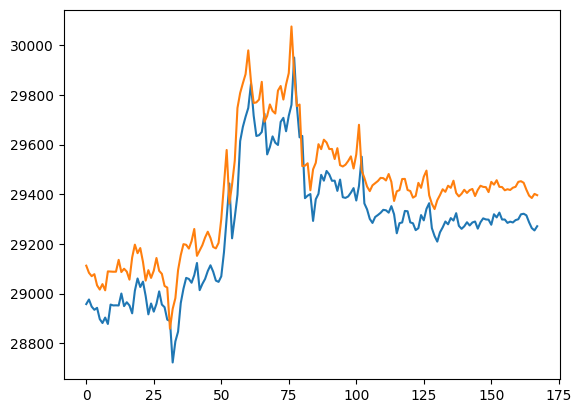

In [65]:
ypred1 = o_predictions[0:24*7]
x0= np.arange(0,24*7,1)
yval1 = close[train_close_len:train_close_len+24*7]
plt.Figure()
plt.plot(x0,ypred1,label='Predicted')
plt.plot(x0,yval1,label='Validation')
plt.show()

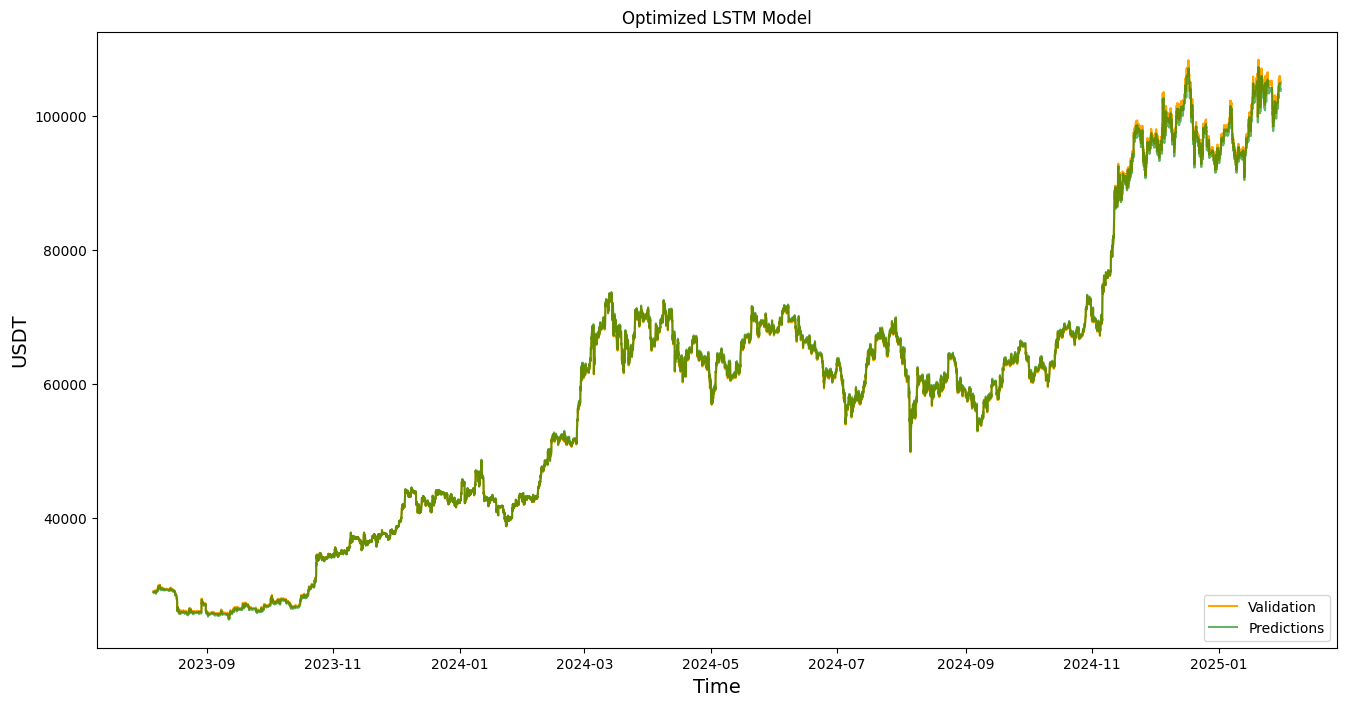

In [66]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][train_close_len:], valid[["Close"]], color="orange")
plt.plot(data["Close Time"][train_close_len:], valid[["Predictions"]], alpha=0.6, color="green")
plt.legend(["Validation", "Predictions"], loc="lower right")
plt.show()

In [67]:
mse3 = np.mean(np.square(valid - o_predictions))
rmse3 = math.sqrt(mse3)
mae3 = np.mean(np.abs(valid - o_predictions))
print(f"Mean Squared Error: {mse3}")
print(f"Root Mean Squared Error: {rmse3}")
print(f"Mean Absolute Error: {mae3}")

Mean Squared Error: 103411.36201597613
Root Mean Squared Error: 321.5763704254032
Mean Absolute Error: 150.63694304580332


In [68]:
model.save_weights("optimized2_model.weights.h5")